In [15]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

from utils.dataset import cifar10_dataset, cifar100_dataset
from models import resnet, vgg, mobilenet, googlenet, densenet

import numpy as np 
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score
from scipy.stats import pearsonr

import os 

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
def load_model(model, state_dict_path, print_layers=False):
    state_dict = torch.load(state_dict_path, map_location=device)
    model.load_state_dict(state_dict)
    model.to(device)
    if print_layers:
        for key in state_dict.keys():
            print(key)
    return model


# fetch embedding features of batches*64 samples
def fetch_features(model, model_ic, data_loader, batches = 1):
    
    non_IC_features = []
    IC_features = []
    
    def forward_hook(module, data_inputs, data_outputs):
        nonlocal non_IC_features

        data_inputs_copy = torch.transpose(data_inputs[0].detach(), 0, 1)
        for i, data_input in enumerate(data_inputs_copy):
            data_input = data_input.cpu().numpy()
            if len(non_IC_features) == 64:
                non_IC_features[i] = np.hstack((non_IC_features[i], data_input))
            else:
                non_IC_features.append(data_input)
            
    def forward_hook_ic(module, data_inputs, data_outputs):
        nonlocal IC_features

        data_inputs_copy = torch.transpose(data_inputs[0].detach(), 0, 1)
        for i, data_input in enumerate(data_inputs_copy):
            data_input = data_input.cpu().numpy()
            if len(IC_features) == 64:
                IC_features[i] = np.hstack((IC_features[i], data_input))
            else:
                IC_features.append(data_input)

    handler = model.linear.register_forward_hook(forward_hook)
    handler_ic = model_ic.linear.register_forward_hook(forward_hook_ic)
    
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        if i==batches:
            break
        else: 
            model(images)
            model_ic(images)

    handler.remove()
    handler_ic.remove()
    
    return non_IC_features, IC_features

# compute per-sample dependence, based on metric func
def compute_dependence(func, features):
    num_feats = len(features)
    mutual_mat = np.empty([num_feats, num_feats])
    for i, feature_1 in enumerate(features):
        for j, feature_2 in enumerate(features):
            mutual_info = abs(func(feature_1, feature_2)[0])
            mutual_mat[i,j] = mutual_info
    return mutual_mat

def run_experiment(model, model_ic, data_loader, batches=20):
    non_IC_features, IC_features = fetch_features(model, model_ic, data_loader, batches)
    mat = compute_dependence(pearsonr, non_IC_features)
    mat_ic = compute_dependence(pearsonr, IC_features)
    return {"res_non_ic": mat, "res_ic": mat_ic}
    
    
    

In [17]:
%ls res/models

model_dir = "./res/models"

densenet40/  googlenet/  resnet110/  vgg16/


In [18]:
# resnet 110 series

# Cifar 10 

print("Experiment: model: resnet110; dataset: cifar10")

model = load_model(
    resnet.resnet110(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_best.pth"), 
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

Experiment: model: resnet110; dataset: cifar10
INFO: Creating resnet110 model
INFO: Creating resnet110 model with IC layer
INFO: Loading CIFAR10 training dataset
Files already downloaded and verified
INFO: Loading CIFAR10 test dataset
Files already downloaded and verified


results of model w/o IC
0.21105200649431155


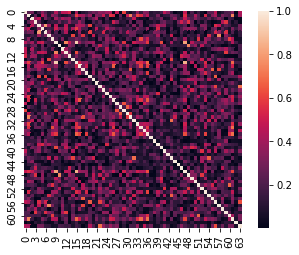

In [19]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

results of model with IC
0.19064009643536728


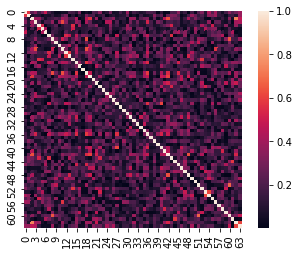

In [20]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [21]:
# Cifar 100

print("Experiment: model: resnet110; dataset: cifar100")

model = load_model(
    resnet.resnet110(num_classes=100),
    os.path.join(model_dir, "resnet110/cifar100_resnet110_best.pth"),
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=100),
    os.path.join(model_dir, "resnet110/cifar100_resnet110_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

Experiment: model: resnet110; dataset: cifar100
INFO: Creating resnet110 model
INFO: Creating resnet110 model with IC layer
INFO: Loading CIFAR100 training dataset
Files already downloaded and verified
INFO: Loading CIFAR100 test dataset
Files already downloaded and verified


results of model w/o IC
0.11036842972891221


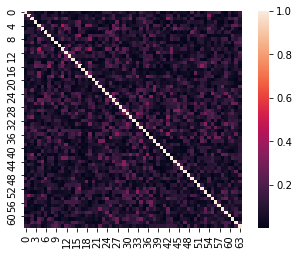

In [25]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

results of model with IC
0.09853173777653054


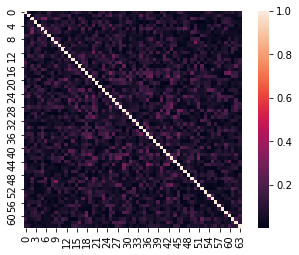

In [23]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [26]:
# resnet 110 series p=0.5
import models.resnet_p05 as resnet_p05

# Cifar 10 

print("Experiment: model: resnet110_p05; dataset: cifar10")

model = load_model(
    resnet_p05.resnet110(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_best_p05.pth"), 
#     True, 
)

model_ic = load_model(
    resnet_p05.resnet110_ic(num_classes=10),
    os.path.join(model_dir, "resnet110/cifar10_resnet110_best_p05.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]


Experiment: model: resnet110_p05; dataset: cifar10
INFO: Creating resnet110 model
INFO: Creating resnet110 model with IC layer


RuntimeError: Error(s) in loading state_dict for ResNet_IC:
	Missing key(s) in state_dict: "ic1.bn.weight", "ic1.bn.bias", "ic1.bn.running_mean", "ic1.bn.running_var", "layer1.0.ic1.bn.weight", "layer1.0.ic1.bn.bias", "layer1.0.ic1.bn.running_mean", "layer1.0.ic1.bn.running_var", "layer1.0.ic2.bn.weight", "layer1.0.ic2.bn.bias", "layer1.0.ic2.bn.running_mean", "layer1.0.ic2.bn.running_var", "layer1.1.ic1.bn.weight", "layer1.1.ic1.bn.bias", "layer1.1.ic1.bn.running_mean", "layer1.1.ic1.bn.running_var", "layer1.1.ic2.bn.weight", "layer1.1.ic2.bn.bias", "layer1.1.ic2.bn.running_mean", "layer1.1.ic2.bn.running_var", "layer1.2.ic1.bn.weight", "layer1.2.ic1.bn.bias", "layer1.2.ic1.bn.running_mean", "layer1.2.ic1.bn.running_var", "layer1.2.ic2.bn.weight", "layer1.2.ic2.bn.bias", "layer1.2.ic2.bn.running_mean", "layer1.2.ic2.bn.running_var", "layer1.3.ic1.bn.weight", "layer1.3.ic1.bn.bias", "layer1.3.ic1.bn.running_mean", "layer1.3.ic1.bn.running_var", "layer1.3.ic2.bn.weight", "layer1.3.ic2.bn.bias", "layer1.3.ic2.bn.running_mean", "layer1.3.ic2.bn.running_var", "layer1.4.ic1.bn.weight", "layer1.4.ic1.bn.bias", "layer1.4.ic1.bn.running_mean", "layer1.4.ic1.bn.running_var", "layer1.4.ic2.bn.weight", "layer1.4.ic2.bn.bias", "layer1.4.ic2.bn.running_mean", "layer1.4.ic2.bn.running_var", "layer1.5.ic1.bn.weight", "layer1.5.ic1.bn.bias", "layer1.5.ic1.bn.running_mean", "layer1.5.ic1.bn.running_var", "layer1.5.ic2.bn.weight", "layer1.5.ic2.bn.bias", "layer1.5.ic2.bn.running_mean", "layer1.5.ic2.bn.running_var", "layer1.6.ic1.bn.weight", "layer1.6.ic1.bn.bias", "layer1.6.ic1.bn.running_mean", "layer1.6.ic1.bn.running_var", "layer1.6.ic2.bn.weight", "layer1.6.ic2.bn.bias", "layer1.6.ic2.bn.running_mean", "layer1.6.ic2.bn.running_var", "layer1.7.ic1.bn.weight", "layer1.7.ic1.bn.bias", "layer1.7.ic1.bn.running_mean", "layer1.7.ic1.bn.running_var", "layer1.7.ic2.bn.weight", "layer1.7.ic2.bn.bias", "layer1.7.ic2.bn.running_mean", "layer1.7.ic2.bn.running_var", "layer1.8.ic1.bn.weight", "layer1.8.ic1.bn.bias", "layer1.8.ic1.bn.running_mean", "layer1.8.ic1.bn.running_var", "layer1.8.ic2.bn.weight", "layer1.8.ic2.bn.bias", "layer1.8.ic2.bn.running_mean", "layer1.8.ic2.bn.running_var", "layer1.9.ic1.bn.weight", "layer1.9.ic1.bn.bias", "layer1.9.ic1.bn.running_mean", "layer1.9.ic1.bn.running_var", "layer1.9.ic2.bn.weight", "layer1.9.ic2.bn.bias", "layer1.9.ic2.bn.running_mean", "layer1.9.ic2.bn.running_var", "layer1.10.ic1.bn.weight", "layer1.10.ic1.bn.bias", "layer1.10.ic1.bn.running_mean", "layer1.10.ic1.bn.running_var", "layer1.10.ic2.bn.weight", "layer1.10.ic2.bn.bias", "layer1.10.ic2.bn.running_mean", "layer1.10.ic2.bn.running_var", "layer1.11.ic1.bn.weight", "layer1.11.ic1.bn.bias", "layer1.11.ic1.bn.running_mean", "layer1.11.ic1.bn.running_var", "layer1.11.ic2.bn.weight", "layer1.11.ic2.bn.bias", "layer1.11.ic2.bn.running_mean", "layer1.11.ic2.bn.running_var", "layer1.12.ic1.bn.weight", "layer1.12.ic1.bn.bias", "layer1.12.ic1.bn.running_mean", "layer1.12.ic1.bn.running_var", "layer1.12.ic2.bn.weight", "layer1.12.ic2.bn.bias", "layer1.12.ic2.bn.running_mean", "layer1.12.ic2.bn.running_var", "layer1.13.ic1.bn.weight", "layer1.13.ic1.bn.bias", "layer1.13.ic1.bn.running_mean", "layer1.13.ic1.bn.running_var", "layer1.13.ic2.bn.weight", "layer1.13.ic2.bn.bias", "layer1.13.ic2.bn.running_mean", "layer1.13.ic2.bn.running_var", "layer1.14.ic1.bn.weight", "layer1.14.ic1.bn.bias", "layer1.14.ic1.bn.running_mean", "layer1.14.ic1.bn.running_var", "layer1.14.ic2.bn.weight", "layer1.14.ic2.bn.bias", "layer1.14.ic2.bn.running_mean", "layer1.14.ic2.bn.running_var", "layer1.15.ic1.bn.weight", "layer1.15.ic1.bn.bias", "layer1.15.ic1.bn.running_mean", "layer1.15.ic1.bn.running_var", "layer1.15.ic2.bn.weight", "layer1.15.ic2.bn.bias", "layer1.15.ic2.bn.running_mean", "layer1.15.ic2.bn.running_var", "layer1.16.ic1.bn.weight", "layer1.16.ic1.bn.bias", "layer1.16.ic1.bn.running_mean", "layer1.16.ic1.bn.running_var", "layer1.16.ic2.bn.weight", "layer1.16.ic2.bn.bias", "layer1.16.ic2.bn.running_mean", "layer1.16.ic2.bn.running_var", "layer1.17.ic1.bn.weight", "layer1.17.ic1.bn.bias", "layer1.17.ic1.bn.running_mean", "layer1.17.ic1.bn.running_var", "layer1.17.ic2.bn.weight", "layer1.17.ic2.bn.bias", "layer1.17.ic2.bn.running_mean", "layer1.17.ic2.bn.running_var", "layer2.0.ic1.bn.weight", "layer2.0.ic1.bn.bias", "layer2.0.ic1.bn.running_mean", "layer2.0.ic1.bn.running_var", "layer2.0.ic2.bn.weight", "layer2.0.ic2.bn.bias", "layer2.0.ic2.bn.running_mean", "layer2.0.ic2.bn.running_var", "layer2.1.ic1.bn.weight", "layer2.1.ic1.bn.bias", "layer2.1.ic1.bn.running_mean", "layer2.1.ic1.bn.running_var", "layer2.1.ic2.bn.weight", "layer2.1.ic2.bn.bias", "layer2.1.ic2.bn.running_mean", "layer2.1.ic2.bn.running_var", "layer2.2.ic1.bn.weight", "layer2.2.ic1.bn.bias", "layer2.2.ic1.bn.running_mean", "layer2.2.ic1.bn.running_var", "layer2.2.ic2.bn.weight", "layer2.2.ic2.bn.bias", "layer2.2.ic2.bn.running_mean", "layer2.2.ic2.bn.running_var", "layer2.3.ic1.bn.weight", "layer2.3.ic1.bn.bias", "layer2.3.ic1.bn.running_mean", "layer2.3.ic1.bn.running_var", "layer2.3.ic2.bn.weight", "layer2.3.ic2.bn.bias", "layer2.3.ic2.bn.running_mean", "layer2.3.ic2.bn.running_var", "layer2.4.ic1.bn.weight", "layer2.4.ic1.bn.bias", "layer2.4.ic1.bn.running_mean", "layer2.4.ic1.bn.running_var", "layer2.4.ic2.bn.weight", "layer2.4.ic2.bn.bias", "layer2.4.ic2.bn.running_mean", "layer2.4.ic2.bn.running_var", "layer2.5.ic1.bn.weight", "layer2.5.ic1.bn.bias", "layer2.5.ic1.bn.running_mean", "layer2.5.ic1.bn.running_var", "layer2.5.ic2.bn.weight", "layer2.5.ic2.bn.bias", "layer2.5.ic2.bn.running_mean", "layer2.5.ic2.bn.running_var", "layer2.6.ic1.bn.weight", "layer2.6.ic1.bn.bias", "layer2.6.ic1.bn.running_mean", "layer2.6.ic1.bn.running_var", "layer2.6.ic2.bn.weight", "layer2.6.ic2.bn.bias", "layer2.6.ic2.bn.running_mean", "layer2.6.ic2.bn.running_var", "layer2.7.ic1.bn.weight", "layer2.7.ic1.bn.bias", "layer2.7.ic1.bn.running_mean", "layer2.7.ic1.bn.running_var", "layer2.7.ic2.bn.weight", "layer2.7.ic2.bn.bias", "layer2.7.ic2.bn.running_mean", "layer2.7.ic2.bn.running_var", "layer2.8.ic1.bn.weight", "layer2.8.ic1.bn.bias", "layer2.8.ic1.bn.running_mean", "layer2.8.ic1.bn.running_var", "layer2.8.ic2.bn.weight", "layer2.8.ic2.bn.bias", "layer2.8.ic2.bn.running_mean", "layer2.8.ic2.bn.running_var", "layer2.9.ic1.bn.weight", "layer2.9.ic1.bn.bias", "layer2.9.ic1.bn.running_mean", "layer2.9.ic1.bn.running_var", "layer2.9.ic2.bn.weight", "layer2.9.ic2.bn.bias", "layer2.9.ic2.bn.running_mean", "layer2.9.ic2.bn.running_var", "layer2.10.ic1.bn.weight", "layer2.10.ic1.bn.bias", "layer2.10.ic1.bn.running_mean", "layer2.10.ic1.bn.running_var", "layer2.10.ic2.bn.weight", "layer2.10.ic2.bn.bias", "layer2.10.ic2.bn.running_mean", "layer2.10.ic2.bn.running_var", "layer2.11.ic1.bn.weight", "layer2.11.ic1.bn.bias", "layer2.11.ic1.bn.running_mean", "layer2.11.ic1.bn.running_var", "layer2.11.ic2.bn.weight", "layer2.11.ic2.bn.bias", "layer2.11.ic2.bn.running_mean", "layer2.11.ic2.bn.running_var", "layer2.12.ic1.bn.weight", "layer2.12.ic1.bn.bias", "layer2.12.ic1.bn.running_mean", "layer2.12.ic1.bn.running_var", "layer2.12.ic2.bn.weight", "layer2.12.ic2.bn.bias", "layer2.12.ic2.bn.running_mean", "layer2.12.ic2.bn.running_var", "layer2.13.ic1.bn.weight", "layer2.13.ic1.bn.bias", "layer2.13.ic1.bn.running_mean", "layer2.13.ic1.bn.running_var", "layer2.13.ic2.bn.weight", "layer2.13.ic2.bn.bias", "layer2.13.ic2.bn.running_mean", "layer2.13.ic2.bn.running_var", "layer2.14.ic1.bn.weight", "layer2.14.ic1.bn.bias", "layer2.14.ic1.bn.running_mean", "layer2.14.ic1.bn.running_var", "layer2.14.ic2.bn.weight", "layer2.14.ic2.bn.bias", "layer2.14.ic2.bn.running_mean", "layer2.14.ic2.bn.running_var", "layer2.15.ic1.bn.weight", "layer2.15.ic1.bn.bias", "layer2.15.ic1.bn.running_mean", "layer2.15.ic1.bn.running_var", "layer2.15.ic2.bn.weight", "layer2.15.ic2.bn.bias", "layer2.15.ic2.bn.running_mean", "layer2.15.ic2.bn.running_var", "layer2.16.ic1.bn.weight", "layer2.16.ic1.bn.bias", "layer2.16.ic1.bn.running_mean", "layer2.16.ic1.bn.running_var", "layer2.16.ic2.bn.weight", "layer2.16.ic2.bn.bias", "layer2.16.ic2.bn.running_mean", "layer2.16.ic2.bn.running_var", "layer2.17.ic1.bn.weight", "layer2.17.ic1.bn.bias", "layer2.17.ic1.bn.running_mean", "layer2.17.ic1.bn.running_var", "layer2.17.ic2.bn.weight", "layer2.17.ic2.bn.bias", "layer2.17.ic2.bn.running_mean", "layer2.17.ic2.bn.running_var", "layer3.0.ic1.bn.weight", "layer3.0.ic1.bn.bias", "layer3.0.ic1.bn.running_mean", "layer3.0.ic1.bn.running_var", "layer3.0.ic2.bn.weight", "layer3.0.ic2.bn.bias", "layer3.0.ic2.bn.running_mean", "layer3.0.ic2.bn.running_var", "layer3.1.ic1.bn.weight", "layer3.1.ic1.bn.bias", "layer3.1.ic1.bn.running_mean", "layer3.1.ic1.bn.running_var", "layer3.1.ic2.bn.weight", "layer3.1.ic2.bn.bias", "layer3.1.ic2.bn.running_mean", "layer3.1.ic2.bn.running_var", "layer3.2.ic1.bn.weight", "layer3.2.ic1.bn.bias", "layer3.2.ic1.bn.running_mean", "layer3.2.ic1.bn.running_var", "layer3.2.ic2.bn.weight", "layer3.2.ic2.bn.bias", "layer3.2.ic2.bn.running_mean", "layer3.2.ic2.bn.running_var", "layer3.3.ic1.bn.weight", "layer3.3.ic1.bn.bias", "layer3.3.ic1.bn.running_mean", "layer3.3.ic1.bn.running_var", "layer3.3.ic2.bn.weight", "layer3.3.ic2.bn.bias", "layer3.3.ic2.bn.running_mean", "layer3.3.ic2.bn.running_var", "layer3.4.ic1.bn.weight", "layer3.4.ic1.bn.bias", "layer3.4.ic1.bn.running_mean", "layer3.4.ic1.bn.running_var", "layer3.4.ic2.bn.weight", "layer3.4.ic2.bn.bias", "layer3.4.ic2.bn.running_mean", "layer3.4.ic2.bn.running_var", "layer3.5.ic1.bn.weight", "layer3.5.ic1.bn.bias", "layer3.5.ic1.bn.running_mean", "layer3.5.ic1.bn.running_var", "layer3.5.ic2.bn.weight", "layer3.5.ic2.bn.bias", "layer3.5.ic2.bn.running_mean", "layer3.5.ic2.bn.running_var", "layer3.6.ic1.bn.weight", "layer3.6.ic1.bn.bias", "layer3.6.ic1.bn.running_mean", "layer3.6.ic1.bn.running_var", "layer3.6.ic2.bn.weight", "layer3.6.ic2.bn.bias", "layer3.6.ic2.bn.running_mean", "layer3.6.ic2.bn.running_var", "layer3.7.ic1.bn.weight", "layer3.7.ic1.bn.bias", "layer3.7.ic1.bn.running_mean", "layer3.7.ic1.bn.running_var", "layer3.7.ic2.bn.weight", "layer3.7.ic2.bn.bias", "layer3.7.ic2.bn.running_mean", "layer3.7.ic2.bn.running_var", "layer3.8.ic1.bn.weight", "layer3.8.ic1.bn.bias", "layer3.8.ic1.bn.running_mean", "layer3.8.ic1.bn.running_var", "layer3.8.ic2.bn.weight", "layer3.8.ic2.bn.bias", "layer3.8.ic2.bn.running_mean", "layer3.8.ic2.bn.running_var", "layer3.9.ic1.bn.weight", "layer3.9.ic1.bn.bias", "layer3.9.ic1.bn.running_mean", "layer3.9.ic1.bn.running_var", "layer3.9.ic2.bn.weight", "layer3.9.ic2.bn.bias", "layer3.9.ic2.bn.running_mean", "layer3.9.ic2.bn.running_var", "layer3.10.ic1.bn.weight", "layer3.10.ic1.bn.bias", "layer3.10.ic1.bn.running_mean", "layer3.10.ic1.bn.running_var", "layer3.10.ic2.bn.weight", "layer3.10.ic2.bn.bias", "layer3.10.ic2.bn.running_mean", "layer3.10.ic2.bn.running_var", "layer3.11.ic1.bn.weight", "layer3.11.ic1.bn.bias", "layer3.11.ic1.bn.running_mean", "layer3.11.ic1.bn.running_var", "layer3.11.ic2.bn.weight", "layer3.11.ic2.bn.bias", "layer3.11.ic2.bn.running_mean", "layer3.11.ic2.bn.running_var", "layer3.12.ic1.bn.weight", "layer3.12.ic1.bn.bias", "layer3.12.ic1.bn.running_mean", "layer3.12.ic1.bn.running_var", "layer3.12.ic2.bn.weight", "layer3.12.ic2.bn.bias", "layer3.12.ic2.bn.running_mean", "layer3.12.ic2.bn.running_var", "layer3.13.ic1.bn.weight", "layer3.13.ic1.bn.bias", "layer3.13.ic1.bn.running_mean", "layer3.13.ic1.bn.running_var", "layer3.13.ic2.bn.weight", "layer3.13.ic2.bn.bias", "layer3.13.ic2.bn.running_mean", "layer3.13.ic2.bn.running_var", "layer3.14.ic1.bn.weight", "layer3.14.ic1.bn.bias", "layer3.14.ic1.bn.running_mean", "layer3.14.ic1.bn.running_var", "layer3.14.ic2.bn.weight", "layer3.14.ic2.bn.bias", "layer3.14.ic2.bn.running_mean", "layer3.14.ic2.bn.running_var", "layer3.15.ic1.bn.weight", "layer3.15.ic1.bn.bias", "layer3.15.ic1.bn.running_mean", "layer3.15.ic1.bn.running_var", "layer3.15.ic2.bn.weight", "layer3.15.ic2.bn.bias", "layer3.15.ic2.bn.running_mean", "layer3.15.ic2.bn.running_var", "layer3.16.ic1.bn.weight", "layer3.16.ic1.bn.bias", "layer3.16.ic1.bn.running_mean", "layer3.16.ic1.bn.running_var", "layer3.16.ic2.bn.weight", "layer3.16.ic2.bn.bias", "layer3.16.ic2.bn.running_mean", "layer3.16.ic2.bn.running_var", "layer3.17.ic1.bn.weight", "layer3.17.ic1.bn.bias", "layer3.17.ic1.bn.running_mean", "layer3.17.ic1.bn.running_var", "layer3.17.ic2.bn.weight", "layer3.17.ic2.bn.bias", "layer3.17.ic2.bn.running_mean", "layer3.17.ic2.bn.running_var", "ic2.bn.weight", "ic2.bn.bias", "ic2.bn.running_mean", "ic2.bn.running_var". 
	Unexpected key(s) in state_dict: "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "bn1.num_batches_tracked", "layer1.0.bn1.weight", "layer1.0.bn1.bias", "layer1.0.bn1.running_mean", "layer1.0.bn1.running_var", "layer1.0.bn1.num_batches_tracked", "layer1.0.bn2.weight", "layer1.0.bn2.bias", "layer1.0.bn2.running_mean", "layer1.0.bn2.running_var", "layer1.0.bn2.num_batches_tracked", "layer1.1.bn1.weight", "layer1.1.bn1.bias", "layer1.1.bn1.running_mean", "layer1.1.bn1.running_var", "layer1.1.bn1.num_batches_tracked", "layer1.1.bn2.weight", "layer1.1.bn2.bias", "layer1.1.bn2.running_mean", "layer1.1.bn2.running_var", "layer1.1.bn2.num_batches_tracked", "layer1.2.bn1.weight", "layer1.2.bn1.bias", "layer1.2.bn1.running_mean", "layer1.2.bn1.running_var", "layer1.2.bn1.num_batches_tracked", "layer1.2.bn2.weight", "layer1.2.bn2.bias", "layer1.2.bn2.running_mean", "layer1.2.bn2.running_var", "layer1.2.bn2.num_batches_tracked", "layer1.3.bn1.weight", "layer1.3.bn1.bias", "layer1.3.bn1.running_mean", "layer1.3.bn1.running_var", "layer1.3.bn1.num_batches_tracked", "layer1.3.bn2.weight", "layer1.3.bn2.bias", "layer1.3.bn2.running_mean", "layer1.3.bn2.running_var", "layer1.3.bn2.num_batches_tracked", "layer1.4.bn1.weight", "layer1.4.bn1.bias", "layer1.4.bn1.running_mean", "layer1.4.bn1.running_var", "layer1.4.bn1.num_batches_tracked", "layer1.4.bn2.weight", "layer1.4.bn2.bias", "layer1.4.bn2.running_mean", "layer1.4.bn2.running_var", "layer1.4.bn2.num_batches_tracked", "layer1.5.bn1.weight", "layer1.5.bn1.bias", "layer1.5.bn1.running_mean", "layer1.5.bn1.running_var", "layer1.5.bn1.num_batches_tracked", "layer1.5.bn2.weight", "layer1.5.bn2.bias", "layer1.5.bn2.running_mean", "layer1.5.bn2.running_var", "layer1.5.bn2.num_batches_tracked", "layer1.6.bn1.weight", "layer1.6.bn1.bias", "layer1.6.bn1.running_mean", "layer1.6.bn1.running_var", "layer1.6.bn1.num_batches_tracked", "layer1.6.bn2.weight", "layer1.6.bn2.bias", "layer1.6.bn2.running_mean", "layer1.6.bn2.running_var", "layer1.6.bn2.num_batches_tracked", "layer1.7.bn1.weight", "layer1.7.bn1.bias", "layer1.7.bn1.running_mean", "layer1.7.bn1.running_var", "layer1.7.bn1.num_batches_tracked", "layer1.7.bn2.weight", "layer1.7.bn2.bias", "layer1.7.bn2.running_mean", "layer1.7.bn2.running_var", "layer1.7.bn2.num_batches_tracked", "layer1.8.bn1.weight", "layer1.8.bn1.bias", "layer1.8.bn1.running_mean", "layer1.8.bn1.running_var", "layer1.8.bn1.num_batches_tracked", "layer1.8.bn2.weight", "layer1.8.bn2.bias", "layer1.8.bn2.running_mean", "layer1.8.bn2.running_var", "layer1.8.bn2.num_batches_tracked", "layer1.9.bn1.weight", "layer1.9.bn1.bias", "layer1.9.bn1.running_mean", "layer1.9.bn1.running_var", "layer1.9.bn1.num_batches_tracked", "layer1.9.bn2.weight", "layer1.9.bn2.bias", "layer1.9.bn2.running_mean", "layer1.9.bn2.running_var", "layer1.9.bn2.num_batches_tracked", "layer1.10.bn1.weight", "layer1.10.bn1.bias", "layer1.10.bn1.running_mean", "layer1.10.bn1.running_var", "layer1.10.bn1.num_batches_tracked", "layer1.10.bn2.weight", "layer1.10.bn2.bias", "layer1.10.bn2.running_mean", "layer1.10.bn2.running_var", "layer1.10.bn2.num_batches_tracked", "layer1.11.bn1.weight", "layer1.11.bn1.bias", "layer1.11.bn1.running_mean", "layer1.11.bn1.running_var", "layer1.11.bn1.num_batches_tracked", "layer1.11.bn2.weight", "layer1.11.bn2.bias", "layer1.11.bn2.running_mean", "layer1.11.bn2.running_var", "layer1.11.bn2.num_batches_tracked", "layer1.12.bn1.weight", "layer1.12.bn1.bias", "layer1.12.bn1.running_mean", "layer1.12.bn1.running_var", "layer1.12.bn1.num_batches_tracked", "layer1.12.bn2.weight", "layer1.12.bn2.bias", "layer1.12.bn2.running_mean", "layer1.12.bn2.running_var", "layer1.12.bn2.num_batches_tracked", "layer1.13.bn1.weight", "layer1.13.bn1.bias", "layer1.13.bn1.running_mean", "layer1.13.bn1.running_var", "layer1.13.bn1.num_batches_tracked", "layer1.13.bn2.weight", "layer1.13.bn2.bias", "layer1.13.bn2.running_mean", "layer1.13.bn2.running_var", "layer1.13.bn2.num_batches_tracked", "layer1.14.bn1.weight", "layer1.14.bn1.bias", "layer1.14.bn1.running_mean", "layer1.14.bn1.running_var", "layer1.14.bn1.num_batches_tracked", "layer1.14.bn2.weight", "layer1.14.bn2.bias", "layer1.14.bn2.running_mean", "layer1.14.bn2.running_var", "layer1.14.bn2.num_batches_tracked", "layer1.15.bn1.weight", "layer1.15.bn1.bias", "layer1.15.bn1.running_mean", "layer1.15.bn1.running_var", "layer1.15.bn1.num_batches_tracked", "layer1.15.bn2.weight", "layer1.15.bn2.bias", "layer1.15.bn2.running_mean", "layer1.15.bn2.running_var", "layer1.15.bn2.num_batches_tracked", "layer1.16.bn1.weight", "layer1.16.bn1.bias", "layer1.16.bn1.running_mean", "layer1.16.bn1.running_var", "layer1.16.bn1.num_batches_tracked", "layer1.16.bn2.weight", "layer1.16.bn2.bias", "layer1.16.bn2.running_mean", "layer1.16.bn2.running_var", "layer1.16.bn2.num_batches_tracked", "layer1.17.bn1.weight", "layer1.17.bn1.bias", "layer1.17.bn1.running_mean", "layer1.17.bn1.running_var", "layer1.17.bn1.num_batches_tracked", "layer1.17.bn2.weight", "layer1.17.bn2.bias", "layer1.17.bn2.running_mean", "layer1.17.bn2.running_var", "layer1.17.bn2.num_batches_tracked", "layer2.0.bn1.weight", "layer2.0.bn1.bias", "layer2.0.bn1.running_mean", "layer2.0.bn1.running_var", "layer2.0.bn1.num_batches_tracked", "layer2.0.bn2.weight", "layer2.0.bn2.bias", "layer2.0.bn2.running_mean", "layer2.0.bn2.running_var", "layer2.0.bn2.num_batches_tracked", "layer2.1.bn1.weight", "layer2.1.bn1.bias", "layer2.1.bn1.running_mean", "layer2.1.bn1.running_var", "layer2.1.bn1.num_batches_tracked", "layer2.1.bn2.weight", "layer2.1.bn2.bias", "layer2.1.bn2.running_mean", "layer2.1.bn2.running_var", "layer2.1.bn2.num_batches_tracked", "layer2.2.bn1.weight", "layer2.2.bn1.bias", "layer2.2.bn1.running_mean", "layer2.2.bn1.running_var", "layer2.2.bn1.num_batches_tracked", "layer2.2.bn2.weight", "layer2.2.bn2.bias", "layer2.2.bn2.running_mean", "layer2.2.bn2.running_var", "layer2.2.bn2.num_batches_tracked", "layer2.3.bn1.weight", "layer2.3.bn1.bias", "layer2.3.bn1.running_mean", "layer2.3.bn1.running_var", "layer2.3.bn1.num_batches_tracked", "layer2.3.bn2.weight", "layer2.3.bn2.bias", "layer2.3.bn2.running_mean", "layer2.3.bn2.running_var", "layer2.3.bn2.num_batches_tracked", "layer2.4.bn1.weight", "layer2.4.bn1.bias", "layer2.4.bn1.running_mean", "layer2.4.bn1.running_var", "layer2.4.bn1.num_batches_tracked", "layer2.4.bn2.weight", "layer2.4.bn2.bias", "layer2.4.bn2.running_mean", "layer2.4.bn2.running_var", "layer2.4.bn2.num_batches_tracked", "layer2.5.bn1.weight", "layer2.5.bn1.bias", "layer2.5.bn1.running_mean", "layer2.5.bn1.running_var", "layer2.5.bn1.num_batches_tracked", "layer2.5.bn2.weight", "layer2.5.bn2.bias", "layer2.5.bn2.running_mean", "layer2.5.bn2.running_var", "layer2.5.bn2.num_batches_tracked", "layer2.6.bn1.weight", "layer2.6.bn1.bias", "layer2.6.bn1.running_mean", "layer2.6.bn1.running_var", "layer2.6.bn1.num_batches_tracked", "layer2.6.bn2.weight", "layer2.6.bn2.bias", "layer2.6.bn2.running_mean", "layer2.6.bn2.running_var", "layer2.6.bn2.num_batches_tracked", "layer2.7.bn1.weight", "layer2.7.bn1.bias", "layer2.7.bn1.running_mean", "layer2.7.bn1.running_var", "layer2.7.bn1.num_batches_tracked", "layer2.7.bn2.weight", "layer2.7.bn2.bias", "layer2.7.bn2.running_mean", "layer2.7.bn2.running_var", "layer2.7.bn2.num_batches_tracked", "layer2.8.bn1.weight", "layer2.8.bn1.bias", "layer2.8.bn1.running_mean", "layer2.8.bn1.running_var", "layer2.8.bn1.num_batches_tracked", "layer2.8.bn2.weight", "layer2.8.bn2.bias", "layer2.8.bn2.running_mean", "layer2.8.bn2.running_var", "layer2.8.bn2.num_batches_tracked", "layer2.9.bn1.weight", "layer2.9.bn1.bias", "layer2.9.bn1.running_mean", "layer2.9.bn1.running_var", "layer2.9.bn1.num_batches_tracked", "layer2.9.bn2.weight", "layer2.9.bn2.bias", "layer2.9.bn2.running_mean", "layer2.9.bn2.running_var", "layer2.9.bn2.num_batches_tracked", "layer2.10.bn1.weight", "layer2.10.bn1.bias", "layer2.10.bn1.running_mean", "layer2.10.bn1.running_var", "layer2.10.bn1.num_batches_tracked", "layer2.10.bn2.weight", "layer2.10.bn2.bias", "layer2.10.bn2.running_mean", "layer2.10.bn2.running_var", "layer2.10.bn2.num_batches_tracked", "layer2.11.bn1.weight", "layer2.11.bn1.bias", "layer2.11.bn1.running_mean", "layer2.11.bn1.running_var", "layer2.11.bn1.num_batches_tracked", "layer2.11.bn2.weight", "layer2.11.bn2.bias", "layer2.11.bn2.running_mean", "layer2.11.bn2.running_var", "layer2.11.bn2.num_batches_tracked", "layer2.12.bn1.weight", "layer2.12.bn1.bias", "layer2.12.bn1.running_mean", "layer2.12.bn1.running_var", "layer2.12.bn1.num_batches_tracked", "layer2.12.bn2.weight", "layer2.12.bn2.bias", "layer2.12.bn2.running_mean", "layer2.12.bn2.running_var", "layer2.12.bn2.num_batches_tracked", "layer2.13.bn1.weight", "layer2.13.bn1.bias", "layer2.13.bn1.running_mean", "layer2.13.bn1.running_var", "layer2.13.bn1.num_batches_tracked", "layer2.13.bn2.weight", "layer2.13.bn2.bias", "layer2.13.bn2.running_mean", "layer2.13.bn2.running_var", "layer2.13.bn2.num_batches_tracked", "layer2.14.bn1.weight", "layer2.14.bn1.bias", "layer2.14.bn1.running_mean", "layer2.14.bn1.running_var", "layer2.14.bn1.num_batches_tracked", "layer2.14.bn2.weight", "layer2.14.bn2.bias", "layer2.14.bn2.running_mean", "layer2.14.bn2.running_var", "layer2.14.bn2.num_batches_tracked", "layer2.15.bn1.weight", "layer2.15.bn1.bias", "layer2.15.bn1.running_mean", "layer2.15.bn1.running_var", "layer2.15.bn1.num_batches_tracked", "layer2.15.bn2.weight", "layer2.15.bn2.bias", "layer2.15.bn2.running_mean", "layer2.15.bn2.running_var", "layer2.15.bn2.num_batches_tracked", "layer2.16.bn1.weight", "layer2.16.bn1.bias", "layer2.16.bn1.running_mean", "layer2.16.bn1.running_var", "layer2.16.bn1.num_batches_tracked", "layer2.16.bn2.weight", "layer2.16.bn2.bias", "layer2.16.bn2.running_mean", "layer2.16.bn2.running_var", "layer2.16.bn2.num_batches_tracked", "layer2.17.bn1.weight", "layer2.17.bn1.bias", "layer2.17.bn1.running_mean", "layer2.17.bn1.running_var", "layer2.17.bn1.num_batches_tracked", "layer2.17.bn2.weight", "layer2.17.bn2.bias", "layer2.17.bn2.running_mean", "layer2.17.bn2.running_var", "layer2.17.bn2.num_batches_tracked", "layer3.0.bn1.weight", "layer3.0.bn1.bias", "layer3.0.bn1.running_mean", "layer3.0.bn1.running_var", "layer3.0.bn1.num_batches_tracked", "layer3.0.bn2.weight", "layer3.0.bn2.bias", "layer3.0.bn2.running_mean", "layer3.0.bn2.running_var", "layer3.0.bn2.num_batches_tracked", "layer3.1.bn1.weight", "layer3.1.bn1.bias", "layer3.1.bn1.running_mean", "layer3.1.bn1.running_var", "layer3.1.bn1.num_batches_tracked", "layer3.1.bn2.weight", "layer3.1.bn2.bias", "layer3.1.bn2.running_mean", "layer3.1.bn2.running_var", "layer3.1.bn2.num_batches_tracked", "layer3.2.bn1.weight", "layer3.2.bn1.bias", "layer3.2.bn1.running_mean", "layer3.2.bn1.running_var", "layer3.2.bn1.num_batches_tracked", "layer3.2.bn2.weight", "layer3.2.bn2.bias", "layer3.2.bn2.running_mean", "layer3.2.bn2.running_var", "layer3.2.bn2.num_batches_tracked", "layer3.3.bn1.weight", "layer3.3.bn1.bias", "layer3.3.bn1.running_mean", "layer3.3.bn1.running_var", "layer3.3.bn1.num_batches_tracked", "layer3.3.bn2.weight", "layer3.3.bn2.bias", "layer3.3.bn2.running_mean", "layer3.3.bn2.running_var", "layer3.3.bn2.num_batches_tracked", "layer3.4.bn1.weight", "layer3.4.bn1.bias", "layer3.4.bn1.running_mean", "layer3.4.bn1.running_var", "layer3.4.bn1.num_batches_tracked", "layer3.4.bn2.weight", "layer3.4.bn2.bias", "layer3.4.bn2.running_mean", "layer3.4.bn2.running_var", "layer3.4.bn2.num_batches_tracked", "layer3.5.bn1.weight", "layer3.5.bn1.bias", "layer3.5.bn1.running_mean", "layer3.5.bn1.running_var", "layer3.5.bn1.num_batches_tracked", "layer3.5.bn2.weight", "layer3.5.bn2.bias", "layer3.5.bn2.running_mean", "layer3.5.bn2.running_var", "layer3.5.bn2.num_batches_tracked", "layer3.6.bn1.weight", "layer3.6.bn1.bias", "layer3.6.bn1.running_mean", "layer3.6.bn1.running_var", "layer3.6.bn1.num_batches_tracked", "layer3.6.bn2.weight", "layer3.6.bn2.bias", "layer3.6.bn2.running_mean", "layer3.6.bn2.running_var", "layer3.6.bn2.num_batches_tracked", "layer3.7.bn1.weight", "layer3.7.bn1.bias", "layer3.7.bn1.running_mean", "layer3.7.bn1.running_var", "layer3.7.bn1.num_batches_tracked", "layer3.7.bn2.weight", "layer3.7.bn2.bias", "layer3.7.bn2.running_mean", "layer3.7.bn2.running_var", "layer3.7.bn2.num_batches_tracked", "layer3.8.bn1.weight", "layer3.8.bn1.bias", "layer3.8.bn1.running_mean", "layer3.8.bn1.running_var", "layer3.8.bn1.num_batches_tracked", "layer3.8.bn2.weight", "layer3.8.bn2.bias", "layer3.8.bn2.running_mean", "layer3.8.bn2.running_var", "layer3.8.bn2.num_batches_tracked", "layer3.9.bn1.weight", "layer3.9.bn1.bias", "layer3.9.bn1.running_mean", "layer3.9.bn1.running_var", "layer3.9.bn1.num_batches_tracked", "layer3.9.bn2.weight", "layer3.9.bn2.bias", "layer3.9.bn2.running_mean", "layer3.9.bn2.running_var", "layer3.9.bn2.num_batches_tracked", "layer3.10.bn1.weight", "layer3.10.bn1.bias", "layer3.10.bn1.running_mean", "layer3.10.bn1.running_var", "layer3.10.bn1.num_batches_tracked", "layer3.10.bn2.weight", "layer3.10.bn2.bias", "layer3.10.bn2.running_mean", "layer3.10.bn2.running_var", "layer3.10.bn2.num_batches_tracked", "layer3.11.bn1.weight", "layer3.11.bn1.bias", "layer3.11.bn1.running_mean", "layer3.11.bn1.running_var", "layer3.11.bn1.num_batches_tracked", "layer3.11.bn2.weight", "layer3.11.bn2.bias", "layer3.11.bn2.running_mean", "layer3.11.bn2.running_var", "layer3.11.bn2.num_batches_tracked", "layer3.12.bn1.weight", "layer3.12.bn1.bias", "layer3.12.bn1.running_mean", "layer3.12.bn1.running_var", "layer3.12.bn1.num_batches_tracked", "layer3.12.bn2.weight", "layer3.12.bn2.bias", "layer3.12.bn2.running_mean", "layer3.12.bn2.running_var", "layer3.12.bn2.num_batches_tracked", "layer3.13.bn1.weight", "layer3.13.bn1.bias", "layer3.13.bn1.running_mean", "layer3.13.bn1.running_var", "layer3.13.bn1.num_batches_tracked", "layer3.13.bn2.weight", "layer3.13.bn2.bias", "layer3.13.bn2.running_mean", "layer3.13.bn2.running_var", "layer3.13.bn2.num_batches_tracked", "layer3.14.bn1.weight", "layer3.14.bn1.bias", "layer3.14.bn1.running_mean", "layer3.14.bn1.running_var", "layer3.14.bn1.num_batches_tracked", "layer3.14.bn2.weight", "layer3.14.bn2.bias", "layer3.14.bn2.running_mean", "layer3.14.bn2.running_var", "layer3.14.bn2.num_batches_tracked", "layer3.15.bn1.weight", "layer3.15.bn1.bias", "layer3.15.bn1.running_mean", "layer3.15.bn1.running_var", "layer3.15.bn1.num_batches_tracked", "layer3.15.bn2.weight", "layer3.15.bn2.bias", "layer3.15.bn2.running_mean", "layer3.15.bn2.running_var", "layer3.15.bn2.num_batches_tracked", "layer3.16.bn1.weight", "layer3.16.bn1.bias", "layer3.16.bn1.running_mean", "layer3.16.bn1.running_var", "layer3.16.bn1.num_batches_tracked", "layer3.16.bn2.weight", "layer3.16.bn2.bias", "layer3.16.bn2.running_mean", "layer3.16.bn2.running_var", "layer3.16.bn2.num_batches_tracked", "layer3.17.bn1.weight", "layer3.17.bn1.bias", "layer3.17.bn1.running_mean", "layer3.17.bn1.running_var", "layer3.17.bn1.num_batches_tracked", "layer3.17.bn2.weight", "layer3.17.bn2.bias", "layer3.17.bn2.running_mean", "layer3.17.bn2.running_var", "layer3.17.bn2.num_batches_tracked". 

results of model w/o IC
0.11036842972891221


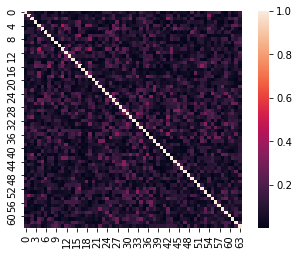

In [27]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

results of model with IC
0.09853173777653054


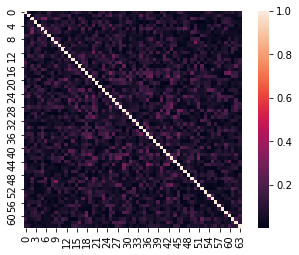

In [28]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [31]:
# VGG16 series

# Cifar 10 

print("Experiment: model: vgg16; dataset: cifar10")

model = load_model(
    vgg.vgg16_bn(num_classes=10),
    os.path.join(model_dir, "vgg16/cifar10_vgg16_best.pth"), 
#     True, 
)

model_ic = load_model(
    vgg.vgg16_bn_ic(num_classes=10),
    os.path.join(model_dir, "vgg16/cifar10_vgg16_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

Experiment: model: vgg16; dataset: cifar10
INFO: Creating VGG-16 Model
INFO: Creating VGG-16 Model with IC layer
INFO: Loading CIFAR10 training dataset
Files already downloaded and verified
INFO: Loading CIFAR10 test dataset
Files already downloaded and verified


AttributeError: 'VGG' object has no attribute 'linear'

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# Cifar 100

print("Experiment: model: vgg16; dataset: cifar100")

model = load_model(
    resnet.resnet110(num_classes=100),
    os.path.join(model_dir, "vgg16/cifar100_vgg16_best.pth"),
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=100),
    os.path.join(model_dir, "vgg16/cifar100_vgg16_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# DenseNet series

# Cifar 10 

print("Experiment: model: densenet40; dataset: cifar10")

model = load_model(
    resnet.resnet110(num_classes=10),
    os.path.join(model_dir, "densenet40/cifar10_densenet40_best.pth"), 
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=10),
    os.path.join(model_dir, "densenet40/cifar10_densenet40_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# Cifar 100

print("Experiment: model: densenet40; dataset: cifar100")

model = load_model(
    resnet.resnet110(num_classes=100),
    os.path.join(model_dir, "densenet40/cifar100_densenet40_best.pth"),
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=100),
    os.path.join(model_dir, "densenet40/cifar100_densenet40_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))

In [ ]:
# GoogleNet series

# Cifar 10 

print("Experiment: model: googlenet; dataset: cifar10")

model = load_model(
    resnet.resnet110(num_classes=10),
    os.path.join(model_dir, "googlenet/cifar10_googlenet_best.pth"), 
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=10),
    os.path.join(model_dir, "googlenet/cifar10_googlenet_ic_best.pth"),
#     True, 
)

_, test_loader = cifar10_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]


In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))


In [ ]:
# Cifar 100

print("Experiment: model: googlenet; dataset: cifar100")

model = load_model(
    resnet.resnet110(num_classes=100),
    os.path.join(model_dir, "googlenet/cifar100_googlenet_best.pth"),
#     True, 
)

model_ic = load_model(
    resnet.resnet110_ic(num_classes=100),
    os.path.join(model_dir, "googlenet/cifar100_googlenet_ic_best.pth"),
#     True, 
)

_, test_loader = cifar100_dataset()

res = run_experiment(model, model_ic, test_loader)
res_non_ic = res["res_non_ic"]
res_ic = res["res_ic"]

In [ ]:
# res_non_ic
print("results of model w/o IC")
sns.heatmap(data=res_non_ic, square=True)
print(np.mean(res_non_ic))

In [ ]:
# res_ic
print("results of model with IC")
sns.heatmap(data=res_ic, square=True)
print(np.mean(res_ic))